# Datan tuonti ja esimerkki

In [ ]:
# Asenna tarvittavat kirjastot
#!pip install tensorflow pandas matplotlib scikit-learn

In [4]:
# Tuo kirjastot
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [5]:
# Hae tiedostopolku
os.path.join("jigsaw-toxic-comment-classification-challenge", "train.csv", "train.csv")

'jigsaw-toxic-comment-classification-challenge\\train.csv\\train.csv'

In [6]:
# Lue data tiedostopolusta
df = pd.read_csv(os.path.join("jigsaw-toxic-comment-classification-challenge", "train.csv", "train.csv"))

In [7]:
# Tässä esimerkki, mitä data sisältää
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
example1 = df.iloc[1]["comment_text"]
example2 = df.iloc[12]["comment_text"]

In [9]:
print("Tämä kommentti ei ole paha kommentti:\n")
print(example1)
df[df.columns[2:]].iloc[1]

Tämä kommentti ei ole paha kommentti:

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)


toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 1, dtype: int64

In [10]:
print("Tämä kommentti on paha kommentti:\n")
print(example2)
df[df.columns[2:]].iloc[12]

Tämä kommentti on paha kommentti:

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 12, dtype: int64

# Datan esikäsittely

In [11]:
# Tuodaan TextVectorization, jotta teksti voidaan muuttaa numeroiksi
from tensorflow.keras.layers import TextVectorization

In [12]:
X = df["comment_text"]
y = df[df.columns[2:]].values

#X # X sisältää kaikki kommentit
#y # y sisältää kaikki labelit (label)

In [13]:
MAX_WORDS = 200000 # Mitä enemmän sanoja kirjastossa, sitä suurempi malli on. Suuri numero vaati videomuistia (VRAM).
# Pienempi numero vaikuttaa mallin tarkkuuteen

In [14]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS, # 
                               output_sequence_length=1800, # Yksi kommentti voi olla maksimissaan 1800 tokenin pituinen
                               output_mode="int") # Jokainen sana muutetaan numeroksi (integer)

In [15]:
vectorizer.adapt(X.values) # Opetetaan kaikki sanat, jotka muutetaan numeroiksi
#vectorizer.get_vocabulary()

Esimerkki:

In [16]:
# Sanat ovat nyt muutettu numeroiksi; Hello = 288, world = 263...
vectorizer("Hello world, how is it going?")

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263,  73, ...,   0,   0,   0], dtype=int64)>

In [17]:
# Muutetaan kommentit tokeneiksi (token)
vectorized_text = vectorizer(X.values)

In [18]:
# Tensorflow data pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000) # Buffer size, näin monta toksista ja ei-toksista kommenttia
dataset = dataset.batch(16) # Jokainen erä on 16 näytettä
dataset = dataset.prefetch(8) # Auttaa pullonkaula-tilanteissa

In [19]:
# Koulutus, validointi ja testaus
train = dataset.take(int(len(dataset)*.7)) # 70% Koulutukseen. Tämä tarkoittaa, että 6981 erää koulutukseen
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) # Skippaa yli koulutus, 20% validointiin
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1)) # Skippa yli koulutus ja validointi, loput 10% testaukseen

# Syväoppimisen toteutus

In [20]:
# Tuo Sequential API
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
# LSTM on suunniteltu käsittelemään aikasarjoja ja sekvenssidataa.
# Droput auttaa vähentämään ylikuormitusta ja parantamaan verkon yleistä yleistettävyyttä.
# Bidirectional kerros käärii annetun kerroksen kaksisuuntaiseksi.
# Dense tarjoaa lasketun tuloksen, joka on yleensä edelleen syötetty aktivointifunktiolle.
# Embedding mahdollistaa tekstin tai kategorisen datan upottamisen tiheään tilaan. Hyödyllinen tässä, kun sanoja käsitellään numeroina.
from matplotlib import pyplot as plt

In [21]:
model = Sequential()
# Luodaan embedding kerros
model.add(Embedding(MAX_WORDS+1, 32))
# Bidirectional LSTM kerros
model.add(Bidirectional(LSTM(32, activation="tanh"))) # tanh aktivointifunktio sillä sitä vaaditaan GPU-kiihdytyksessä LSTM kerroksessa
# Yhdistetyt kerrokset, relu aktivointifunktio
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
# Viimeinen kerros, sigmoid aktivointifunktio
model.add(Dense(6, activation="sigmoid"))

In [22]:
model.compile(loss="BinaryCrossentropy", optimizer="Adam")

In [23]:
# Tässä malli
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [24]:
# Koulutetaan malli HUOM! TÄSSÄ MENEE KAUAN!
# Jotta malli olisi vielä parempi, kannattaa erät nostaa esim. kymmeneen
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 2334s 334ms/step - loss: 0.0642 - val_loss: 0.0458
Epoch 2/5
6981/6981 [==============================] - 2422s 347ms/step - loss: 0.0459 - val_loss: 0.0420
Epoch 3/5
6981/6981 [==============================] - 2370s 339ms/step - loss: 0.0411 - val_loss: 0.0367
Epoch 4/5
6981/6981 [==============================] - 2763s 396ms/step - loss: 0.0371 - val_loss: 0.0326
Epoch 5/5
6981/6981 [==============================] - 2662s 381ms/step - loss: 0.0324 - val_loss: 0.0291


In [25]:
# Test loss ja validation loss
history.history

{'loss': [0.0641956478357315,
  0.045900311321020126,
  0.04111779108643532,
  0.03706657513976097,
  0.03241785243153572],
 'val_loss': [0.04583281651139259,
  0.04198877513408661,
  0.03672349452972412,
  0.03264028951525688,
  0.029069021344184875]}

<Figure size 800x500 with 0 Axes>

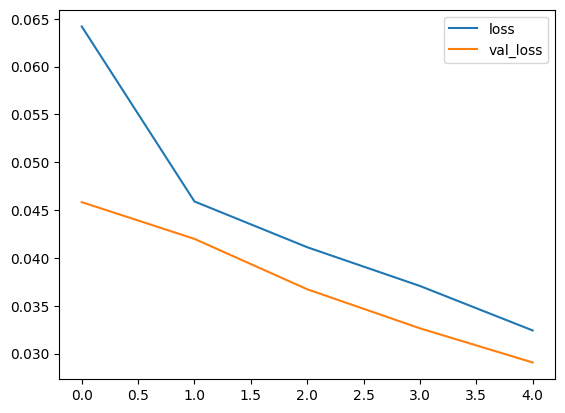

In [26]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Ennusteet

In [96]:
input_text = vectorizer("You freaking suck! Matchmake again and I'm going to harm you.")

In [97]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [154]:
model.predict(np.expand_dims(input_text, 0), verbose = 0)

array([[0.99929094, 0.37770575, 0.97818667, 0.1068709 , 0.93760234,
        0.32767695]], dtype=float32)

Malli olettaa (arvo yli tai ali 0,5), että:
* kommentti on toksinen
* kommentti ei ole vakavan toksinen
* kommentti on säädytön
* kommentti ei ole uhkaus
* kommentti on loukkaus
* kommentti ei ole identiteettiloukkaus

Mallia voisi siis kouluttaa enemmän esim. uhkauksen kohdalla

In [99]:
batch = test.as_numpy_iterator().next()

In [100]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [101]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=int64)

In [102]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 78ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

# Arviointi

In [104]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [180]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true, verbose = 0)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [119]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [181]:
print(f"Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}")

Precision: 0.8707172274589539, Recall:0.8291763067245483, Accuracy:0.5025075078010559


# Miten tuloksia voisi parantaa?

Testierän voisi nostaa esimerkiksi kymmeneen. Pitää kuitenkin varoa ylisovittamista, johon voisi auttaa esimerkiksi dropout-kerros.
Tämä tuli huomattua, kun testieriä nostamalla Precision ja Recall nousevat, mutta Accuracy laskee.

Malli on simppeli ja toimii kohtalaisen hyvin. Yleisesti mallin parantamiseksi tarvisi varmasti vielä enemmän näytteitä.